# Codestates Project 2 - Data Science Field Salary

질문. 나와 동기들의 10년뒤 연봉은 얼마나 될까?

Dataset : data_0_Levels_Fyi_Salary_Data.csv  
From : https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries  

Features
- timestamp : 기록시간인듯?
- company : 회사 1632개
- level : 직급인듯? (약 3000)
- title : 하는일
- totalyearlycompensation : 총급여
- location : 위치
- years of experience : 경력
- years at company : 근속연수
- tag : 하는일
- basesalary : 기본급여
- stock grant value : 스톡옵션
- bonus : 보너스
- gender : 성별
- cityid : 도시번호?
- dmaid : media market, 지역분할 방식인듯?
- degree : 학위
- race : 인종  
       [nan, 'White', 'Asian', 'Black', 'Two Or More', 'Hispanic']
- education : 교육  
       [nan, 'PhD', "Master's Degree", "Bachelor's Degree", 'Some College', 'Highschool']

Dataset : data_1_india_data_field.csv  
From : https://www.kaggle.com/datasets/jaiganeshnagidi/data-scientist-salary

Dataset : data_2_cleaned_2021.csv  
From : https://www.kaggle.com/datasets/nikhilbhathi/data-scientist-salary-us-glassdoor  

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import missingno as msno

from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

import category_encoders

from lightgbm import LGBMRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from pdpbox.pdp import pdp_interact, pdp_interact_plot

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 30)


In [101]:
df_0 = pd.read_csv("data_0_Levels_Fyi_Salary_Data.csv")
print(df_0.shape)
df_0.head(5).T

(62642, 29)


,0,1,2,3,4
timestamp,6/7/2017 11:33:27,6/10/2017 17:11:29,6/11/2017 14:53:57,6/17/2017 0:23:14,6/20/2017 10:58:51
company,Oracle,eBay,Amazon,Apple,Microsoft
level,L3,SE 2,L7,M1,60
title,Product Manager,Software Engineer,Product Manager,Software Engineering Manager,Software Engineer
totalyearlycompensation,127000,100000,310000,372000,157000
location,"Redwood City, CA","San Francisco, CA","Seattle, WA","Sunnyvale, CA","Mountain View, CA"
yearsofexperience,1.5,5,8,7,5
yearsatcompany,1.5,3,0,5,3
tag,NaN,NaN,NaN,NaN,NaN
basesalary,107000,0,155000,157000,0


In [102]:
# drop unsued
df_0 = df_0.drop(["otherdetails", "dmaid", "rowNumber"], axis=1)

# change columns name
df_0 = df_0.rename(
    columns = {"totalyearlycompensation":"annual_income",
               "yearsofexperience":"years_of_experience"},
    )

# set target
target = "annual_income"

In [103]:
# msno.matrix(df_0, figsize=(12, 8))

In [104]:
# 결측치 처리
df_0.isna().sum()
# company : drop
df_0_cln = df_0.dropna(subset=["company"])

# tag, gender : nan -> no_answer
nan_cols = ["tag", "gender", "Race", "Education"]
df_0_cln[nan_cols] = df_0_cln[nan_cols].fillna("no_answer")

# 
df_0_cln.isna().sum()

c:\Users\TESB\anaconda3\envs\py36_pdpbox\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


timestamp                0
company                  0
level                  119
title                    0
annual_income            0
location                 0
years_of_experience      0
yearsatcompany           0
tag                      0
basesalary               0
stockgrantvalue          0
bonus                    0
gender                   0
cityid                   0
Masters_Degree           0
Bachelors_Degree         0
Doctorate_Degree         0
Highschool               0
Some_College             0
Race_Asian               0
Race_White               0
Race_Two_Or_More         0
Race_Black               0
Race_Hispanic            0
Race                     0
Education                0
dtype: int64

In [105]:
# 이상치 처리
# df_0_cln[df_0_cln.gender == 'Title: Senior Software Engineer'].T
df_0_cln.at[11010,"gender"] = "no_answer"
df_0_cln.gender.unique()


array(['no_answer', 'Male', 'Female', 'Other'], dtype=object)

In [106]:

# 낮은 이상치 : 제1사분위수 - 1.5 * 사분위편차 보다 작은 값
# 높은 이상치 : 제3사분위수 + 1.5 * 사분위편차 보다 높은 값
q0 = df_0_cln[target].quantile(q=0)
q1 = df_0_cln[target].quantile(q=0.25)
q2 = df_0_cln[target].quantile(q=0.5)
q3 = df_0_cln[target].quantile(q=0.75)
q4 = df_0_cln[target].quantile(q=1)

print(q0, q1, q2, q3, q4)
min = q1 - (1.5 * q1)
max = q3 + (1.5 * q3)
print(min, max)

df_0_cln


10000.0 135000.0 188000.0 264000.0 4980000.0
-67500.0 660000.0


,timestamp,company,level,title,annual_income,location,years_of_experience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,no_answer,107000.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,no_answer,0.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,no_answer,155000.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,no_answer,157000.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,no_answer,0.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,"Seattle, WA",10.0,1.0,Distributed Systems (Back-End),155000.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,"Redmond, WA",2.0,2.0,Full Stack,146900.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,"Seattle, WA",14.0,12.0,Full Stack,157000.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,"San Francisco, CA",8.0,4.0,iOS,194688.0,...,0,0,0,0,0,0,0,0,no_answer,no_answer


0.0 3.0 6.0 10.0 69.0
-1.5 25.0


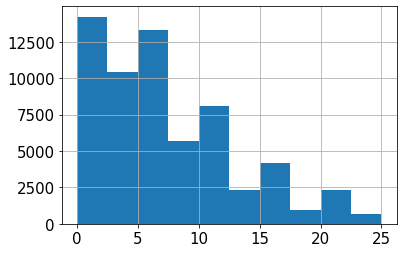

In [107]:
q0 = df_0_cln["years_of_experience"].quantile(q=0)
q1 = df_0_cln["years_of_experience"].quantile(q=0.25)
q2 = df_0_cln["years_of_experience"].quantile(q=0.5)
q3 = df_0_cln["years_of_experience"].quantile(q=0.75)
q4 = df_0_cln["years_of_experience"].quantile(q=1)

print(q0, q1, q2, q3, q4)
min = q1 - (1.5 * q1)
max = q3 + (1.5 * q3)
print(min, max)

df_0_cln = df_0_cln[df_0_cln.years_of_experience <= (max)]
df_0_cln.years_of_experience.hist()

In [108]:
# 실험실

# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)data")][["tag","title"]] # 1941
# df_0_cln.tag.str.contains("(?i)data")
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)iphone")][["tag","title"]] # ios
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)android")][["tag","title"]] # ios
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)data engineer")][["tag","title"]] # 67

# temp = df_0_cln[(df_0_cln.tag.str.contains("(?i)anal")) & (df_0_cln.title == "Data Scientist")] # 187
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)data science")][["tag","title"]] # 25



# temp = df_0_cln.location.str.split(pat=", ",n=2,expand=True)
# countries = []
# for i in temp.index:
#     country = temp.at[i,2]
#     countries.append(("U.S." if pd.isna(country) else country))
# countries

# for i in temp.index:
#     if pd.isna(temp.at[i,3]) :
#         countries.append("U.S.")
#     else:
#         countries.append(temp[i,3])

# [ "U.S." if False else temp[2] ]

# temp = temp.str.split(pat=" ",n=1, expand=True)
# df_0_cln.location

# df.info()
    
# temp
# temp.tag.unique()

In [109]:
# feature engineering
from unicodedata import category


def feature_engineering(df):

    # 날짜 분리
    df.timestamp = pd.to_datetime(df.timestamp)
    df["year"] = df["timestamp"].dt.year
    df["date"] = df["timestamp"].dt.date.astype(str)
    df["date"] = df["date"].str.replace("-","").astype(int)

    # 직무 관련 특성 생성
    ml = df.tag.str.contains("(?i)ml")
    machine = df.tag.str.contains("(?i)machine") & ~df.tag.str.contains("Machine Vision")
    data_woker = df.title == "Data Scientist"
    software_engineer = df.title == "Software Engineer"
    software_enginerr_mng = df.title == "Software Engineering Manager"
    abt_data = df.tag.str.contains("(?i)data")
    data_scientist = ((df.tag.str.contains("(?i)data science")) | (df.tag.str.contains("(?i)data scientist")))

    df["developer"]       = data_woker | software_engineer | software_enginerr_mng
    df["data_woker"]      = data_woker
    df["machin_learning"] = ml | machine
    df["ai"]              = df.tag.str.contains("(?i)ai") & ~df.tag.str.contains("(?i)ai[a-z]")
    df["data_analytics"]  = df.tag.str.contains("(?i)anal") & data_woker
    df["data_scientist"]  = data_scientist
    df["data_engineer"]   = df.tag.str.contains("(?i)data engineer")
    df["data_area"]       = (
        (abt_data & data_woker)
        | (abt_data & software_engineer)
        | (abt_data & software_enginerr_mng)
        | (df["machin_learning"])
        | (df["ai"])
        | (df["data_analytics"])
        | (df["data_scientist"])
        | (df["data_engineer"])
    )

    df["ios"] = df.tag.str.contains("(?i)ios")
    df["android"] = df.tag.str.contains("(?i)android")

    # 지역 데이터 분리
    temp = df.location.str.split(pat=", ", n=2, expand=True)
    df["city"] = temp[0]
    df["state"] = temp[1]
    countries = []
    for i in temp.index:
        country = temp.at[i, 2]
        countries.append(("U.S." if pd.isna(country) else country))
    df["country"] = countries
  
    # Drop columns
    drop_cols = [
        "timestamp",
        "Masters_Degree",
        "Bachelors_Degree",
        "Doctorate_Degree",
        "Highschool",
        "Some_College",
        "Race",
        "location",
    ]
    df = df.drop(drop_cols, axis=1)

    return df


df_0_eng = feature_engineering(df_0_cln.copy())


In [110]:
# 표본이 많은 상위 20개국 + 한국

countries = df_0_eng["country"].value_counts()[:15].index.to_list()
countries.append("Korea, South")
countries.append("Japan")
countries.append("China")
countries

df_0_flt = df_0_eng[df_0_eng["country"].isin(countries)]


([<matplotlib.patches.Wedge at 0x2c7dac24d68>,
 [Text(-0.9690583658696615, 0.5205054116318306, 'U.S.'),
  Text(0.7316087635845885, -0.821430835217567, 'India'),
  Text(0.9013820554692735, -0.6304842504599046, 'Canada'),
  Text(0.9855309919315087, -0.4885986737011232, 'United Kingdom'),
  Text(1.0250398854231144, -0.39911556383053864, 'Germany'),
  Text(1.0429331904330659, -0.3497003864640507, 'Singapore'),
  Text(1.0544418309649146, -0.3132928743386267, 'Ireland'),
  Text(1.0638379844622654, -0.27972976748151895, 'Taiwan'),
  Text(1.0718675664036088, -0.24718398024954122, 'Israel'),
  Text(1.0783464270660774, -0.21718421497389118, 'Australia'),
  Text(1.083634793371328, -0.1890387118954197, 'Netherlands'),
  Text(1.0880911353628788, -0.16142391751138244, 'Russia'),
  Text(1.0913648292333182, -0.13756020322946022, 'Switzerland'),
  Text(1.0932300354079207, -0.12185273768773752, 'Spain'),
  Text(1.0944039923792424, -0.11081471682216003, 'China'),
  Text(1.0954614694199594, -0.09982068431

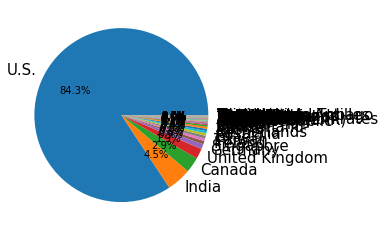

In [111]:
# df_0_flt.country.unique()
temp = df_0_eng["country"].value_counts()

plt.pie(temp.values, labels=temp.index,  autopct='%.1f%%')


In [112]:
# temp = df_0_flt[["developer","level","years_of_experience",target]]
df_0_flt[df_0_flt.annual_income > 3000000]
# sns.barplot(data=df_0_flt,x="developer",y=target)

,company,level,title,annual_income,years_of_experience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,...,ai,data_analytics,data_scientist,data_engineer,data_area,ios,android,city,state,country
61967,Microsoft,80,Software Engineering Manager,4950000,24.0,8.0,ML / AI,850000.0,3750.0,350000.0,...,True,False,False,False,True,False,False,Redmond,WA,U.S.
61982,Google,L10,Product Manager,4500000,20.0,14.0,Consumer,450000.0,3700.0,350000.0,...,False,False,False,False,False,False,False,San Francisco,CA,U.S.
61990,Facebook,E9,Software Engineer,4490000,13.0,9.0,Full Stack,350000.0,4000.0,140000.0,...,False,False,False,False,False,False,False,Menlo Park,CA,U.S.
61991,Facebook,E9,Product Manager,4980000,17.0,0.0,Product,380000.0,4400.0,200000.0,...,False,False,False,False,False,False,False,Menlo Park,CA,U.S.


In [113]:
def column_avg(df, col, agg="mean", orient="v"):
    temp = df[[col,target]]
    if agg == "mean":
        temp = temp.groupby(col).agg(np.mean)
    elif agg == "median":
        temp = temp.groupby(col).agg(np.median)
    temp = temp.reset_index(col)
    temp = temp.sort_values(target,ascending=False)
    print(temp.annual_income.values.round(0))
    plt.close("all")
    plt.figure(figsize=(8,8), dpi=300)
    # palette = sns.color_palette("#69d", reverse=True, as_cmap=True)
    # palette = sns.color_palette("Dark2")
    # sns.set_palette(palette=palette)
    
    plt.rc('xtick', labelsize=15); 
    plt.rc('ytick', labelsize=15);
    palette = "mako"
    
    if(orient == "v"):
        sns.barplot(data=temp,x=col,y=target, orient=orient, palette=palette)
        
        # put comma
        current_values = plt.gca().get_yticks();
        plt.gca().set_yticklabels([format(int(x),',') for x in current_values]);
        
    else :
        sns.barplot(data=temp,x=target,y=col, orient=orient, palette=palette)
        
        # put comma
        current_values = plt.gca().get_xticks();
        plt.gca().set_xticklabels([format(int(x),',') for x in current_values]);
        

[252205. 234551. 176747. 160638. 155900. 145038. 139685. 138576. 138095.
 132380. 127083. 121970. 113546.  82830.  76900.  62695.  59773.]


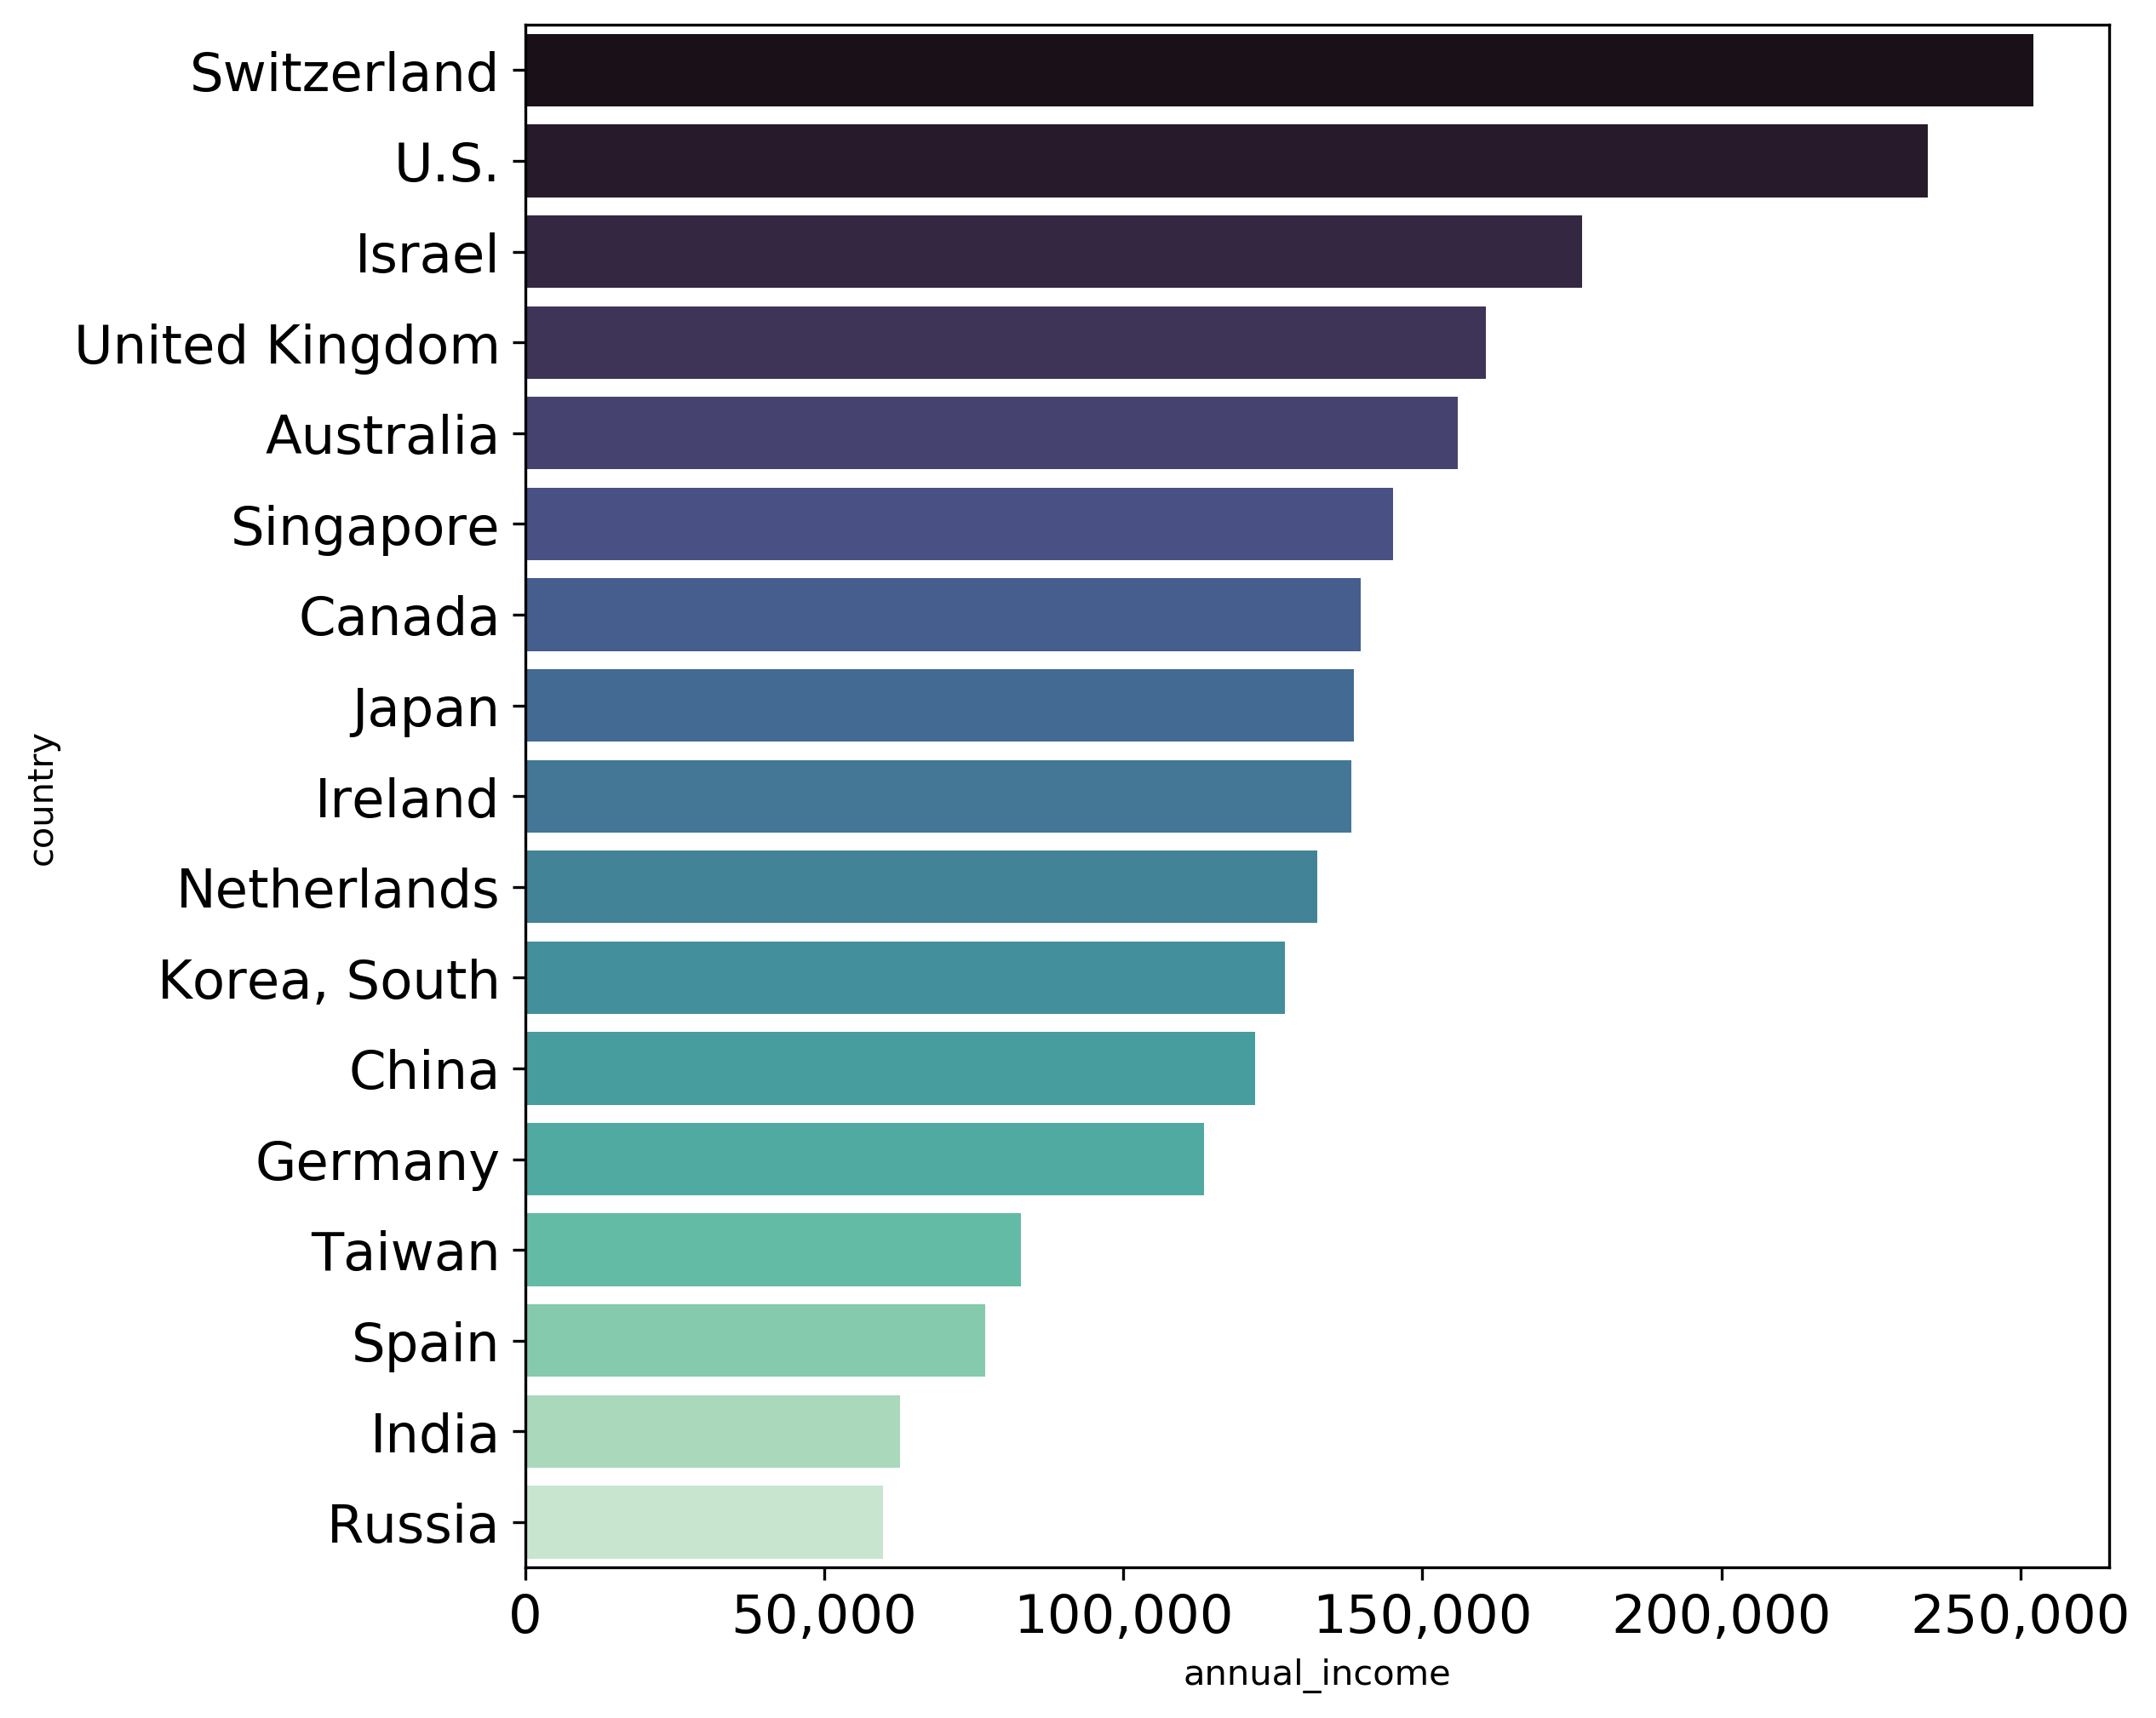

In [114]:
column_avg(df=df_0_flt.copy(), col="country",orient="h")

In [115]:
# encoding
# ordinal
def encodings(df):
    
    degrees = [
            "no_answer", 
            "Highschool",
            "Some College",
            "Bachelor's Degree",
            "Master's Degree",
            "PhD",
        ]
    edu_enc = OrdinalEncoder(categories=[degrees])
    df[["Education"]] = edu_enc.fit_transform(X=df[["Education"]]).astype(int)
    
    
    label_cols = [
        "company",
        "title",
        "gender",
        "country",
        "state",
        "city",
        "level",
    ]
    ord_enc = category_encoders.OrdinalEncoder(cols=label_cols)
    df[label_cols] = ord_enc.fit_transform(df[label_cols])

    return df

df_0_enc = encodings(df_0_flt.copy())


In [116]:
df_0_enc.head().T
# df_0_eng.loc[61987]

,0,1,2,3,4
company,1,2,3,4,5
level,1,2,3,4,5
title,1,2,1,3,2
annual_income,127000,100000,310000,372000,157000
years_of_experience,1.5,5,8,7,5
...,...,...,...,...,...
ios,False,False,False,False,False
android,False,False,False,False,False
city,1,2,3,4,5
state,1,1,2,1,1


In [117]:
df_0_enc.columns

Index(['company', 'level', 'title', 'annual_income', 'years_of_experience',
       'yearsatcompany', 'tag', 'basesalary', 'stockgrantvalue', 'bonus',
       'gender', 'cityid', 'Race_Asian', 'Race_White', 'Race_Two_Or_More',
       'Race_Black', 'Race_Hispanic', 'Education', 'year', 'date', 'developer',
       'data_woker', 'machin_learning', 'ai', 'data_analytics',
       'data_scientist', 'data_engineer', 'data_area', 'ios', 'android',
       'city', 'state', 'country'],
      dtype='object')

In [118]:
using_features = [
    'company', 
    'level',
    # 'title', 
    'annual_income', 
    'years_of_experience',
    # 'yearsatcompany', 
    # 'tag', 
    # 'basesalary', 
    # 'stockgrantvalue', 
    # 'bonus',
    'gender', 
    'cityid', 
    'Race_Asian', 
    'Race_White', 
    'Race_Two_Or_More',
    'Race_Black', 
    'Race_Hispanic', 
    'Education', 
    # "Masters_Degree",
    # "Bachelors_Degree",
    # "Doctorate_Degree",
    # "Highschool",
    # "Some_College",
    'year', 
    # 'date', 
    'developer',
    'data_woker', 
    'machin_learning', 
    'ai', 
    'data_analytics',
    'data_scientist', 
    'data_engineer', 
    'data_area', 
    # 'ios', 
    # 'android',
    # 'city', 
    # 'state', 
    'country']

df_0_final = df_0_enc[using_features]
    # astype
categoricals = ["country","gender","cityid"]
df_0_final[categoricals] = df_0_final[categoricals].astype("category")

df_0_final.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 61437 entries, 0 to 62641
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   company              61437 non-null  int32   
 1   level                61437 non-null  int32   
 2   annual_income        61437 non-null  int64   
 3   years_of_experience  61437 non-null  float64 
 4   gender               61437 non-null  category
 5   cityid               61437 non-null  category
 6   Race_Asian           61437 non-null  int64   
 7   Race_White           61437 non-null  int64   
 8   Race_Two_Or_More     61437 non-null  int64   
 9   Race_Black           61437 non-null  int64   
 10  Race_Hispanic        61437 non-null  int64   
 11  Education            61437 non-null  int64   
 12  year                 61437 non-null  int64   
 13  developer            61437 non-null  bool    
 14  data_woker           61437 non-null  bool    
 15  machin_learning    

c:\Users\TESB\anaconda3\envs\py36_pdpbox\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[217560. 216035.]


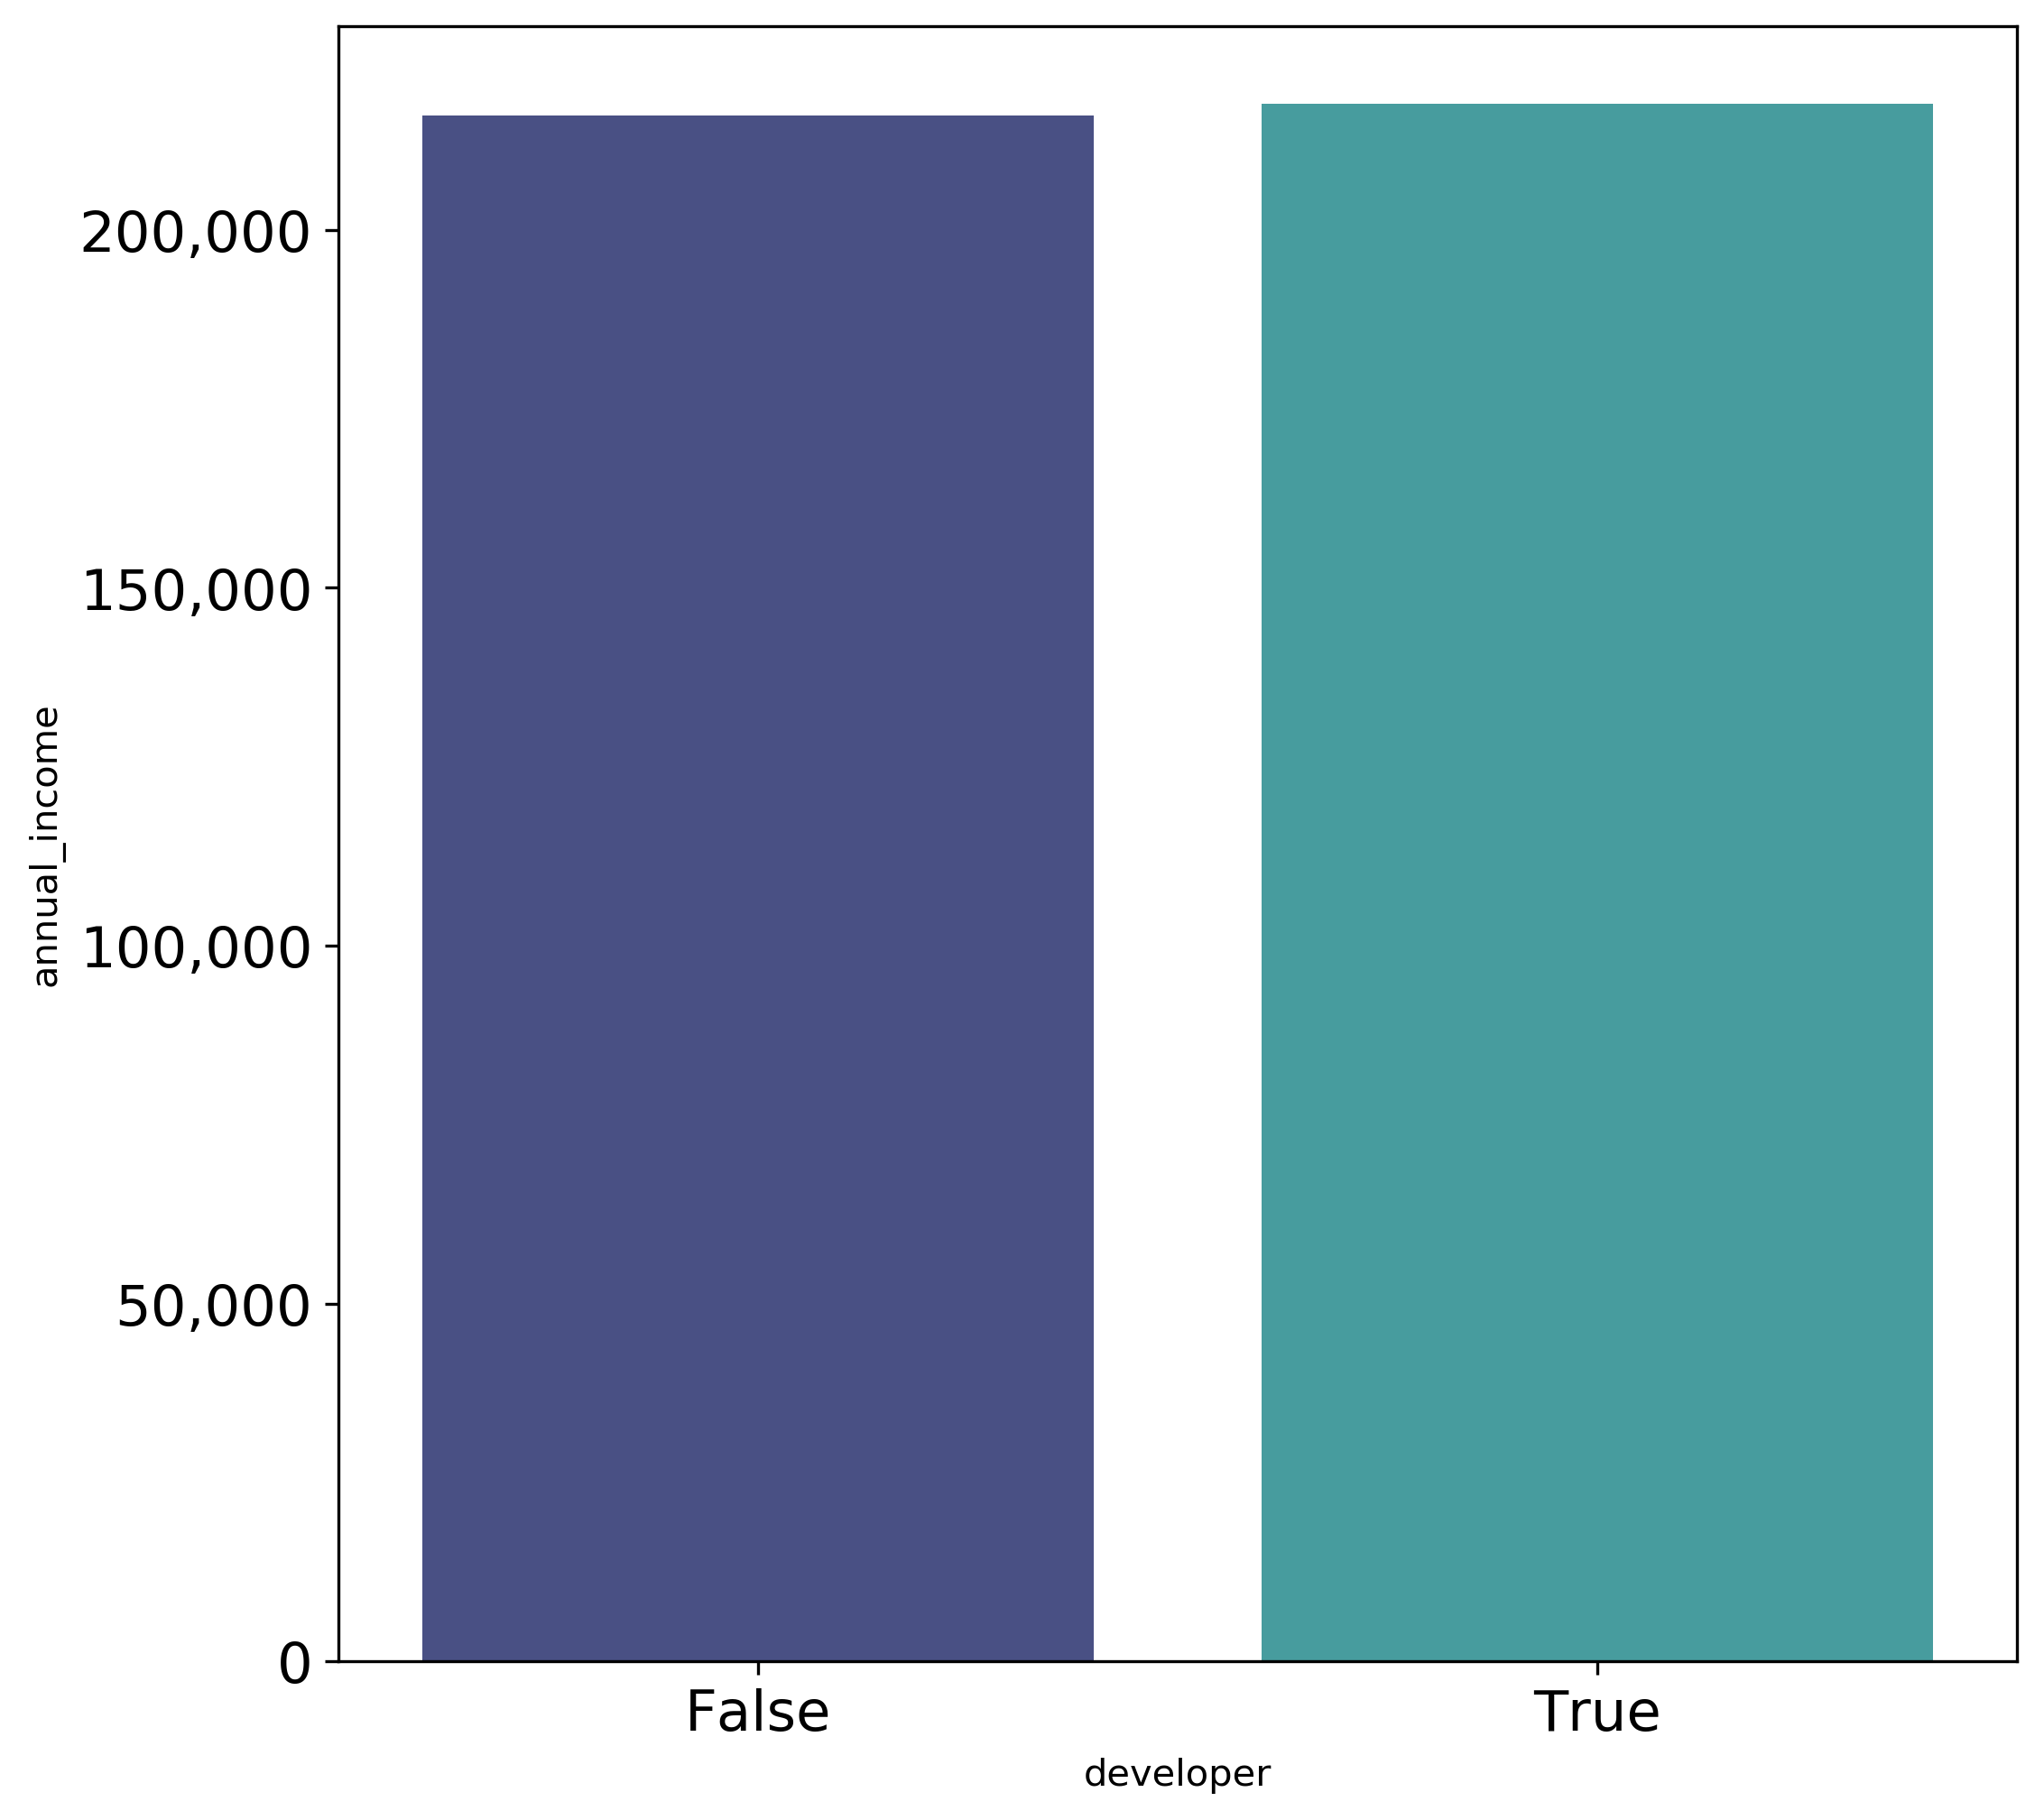

In [119]:
column_avg(df_0_final.copy(),"developer",agg="mean")

# temp = df_0_final[["developer",target]]
# temp = temp.groupby("developer").agg(np.mean)
# temp = temp.reset_index("developer")
# print(temp.annual_income.values.round(0))
# sns.barplot(data=temp,x="developer",y=target)

In [120]:
temp = df_0_final[["developer","level",target]]
temp[temp.annual_income > 3000000]
# sns.boxplot(data=temp,x="developer", y=target, )
# temp = temp.groupby("developer").agg(np.mean)
# temp = temp.reset_index("developer")
# print(temp.annual_income.values.round(0))
# sns.barplot(data=temp,x="developer",y=target)

,developer,level,annual_income
61967,True,2257,4950000
61982,False,151,4500000
61990,True,1531,4490000
61991,False,1531,4980000


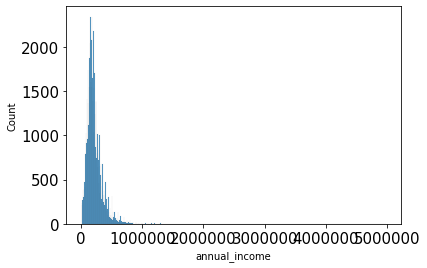

In [121]:
# df_0_enc["yearsofexperience"].describe()
plt.close("all")
sns.histplot(df_0_enc[target])
# plt.hist(df_0_cln["yearsofexperience"])
# xticks = range(0,70)

# plt.xticks(xticks)

[244150. 214171.]


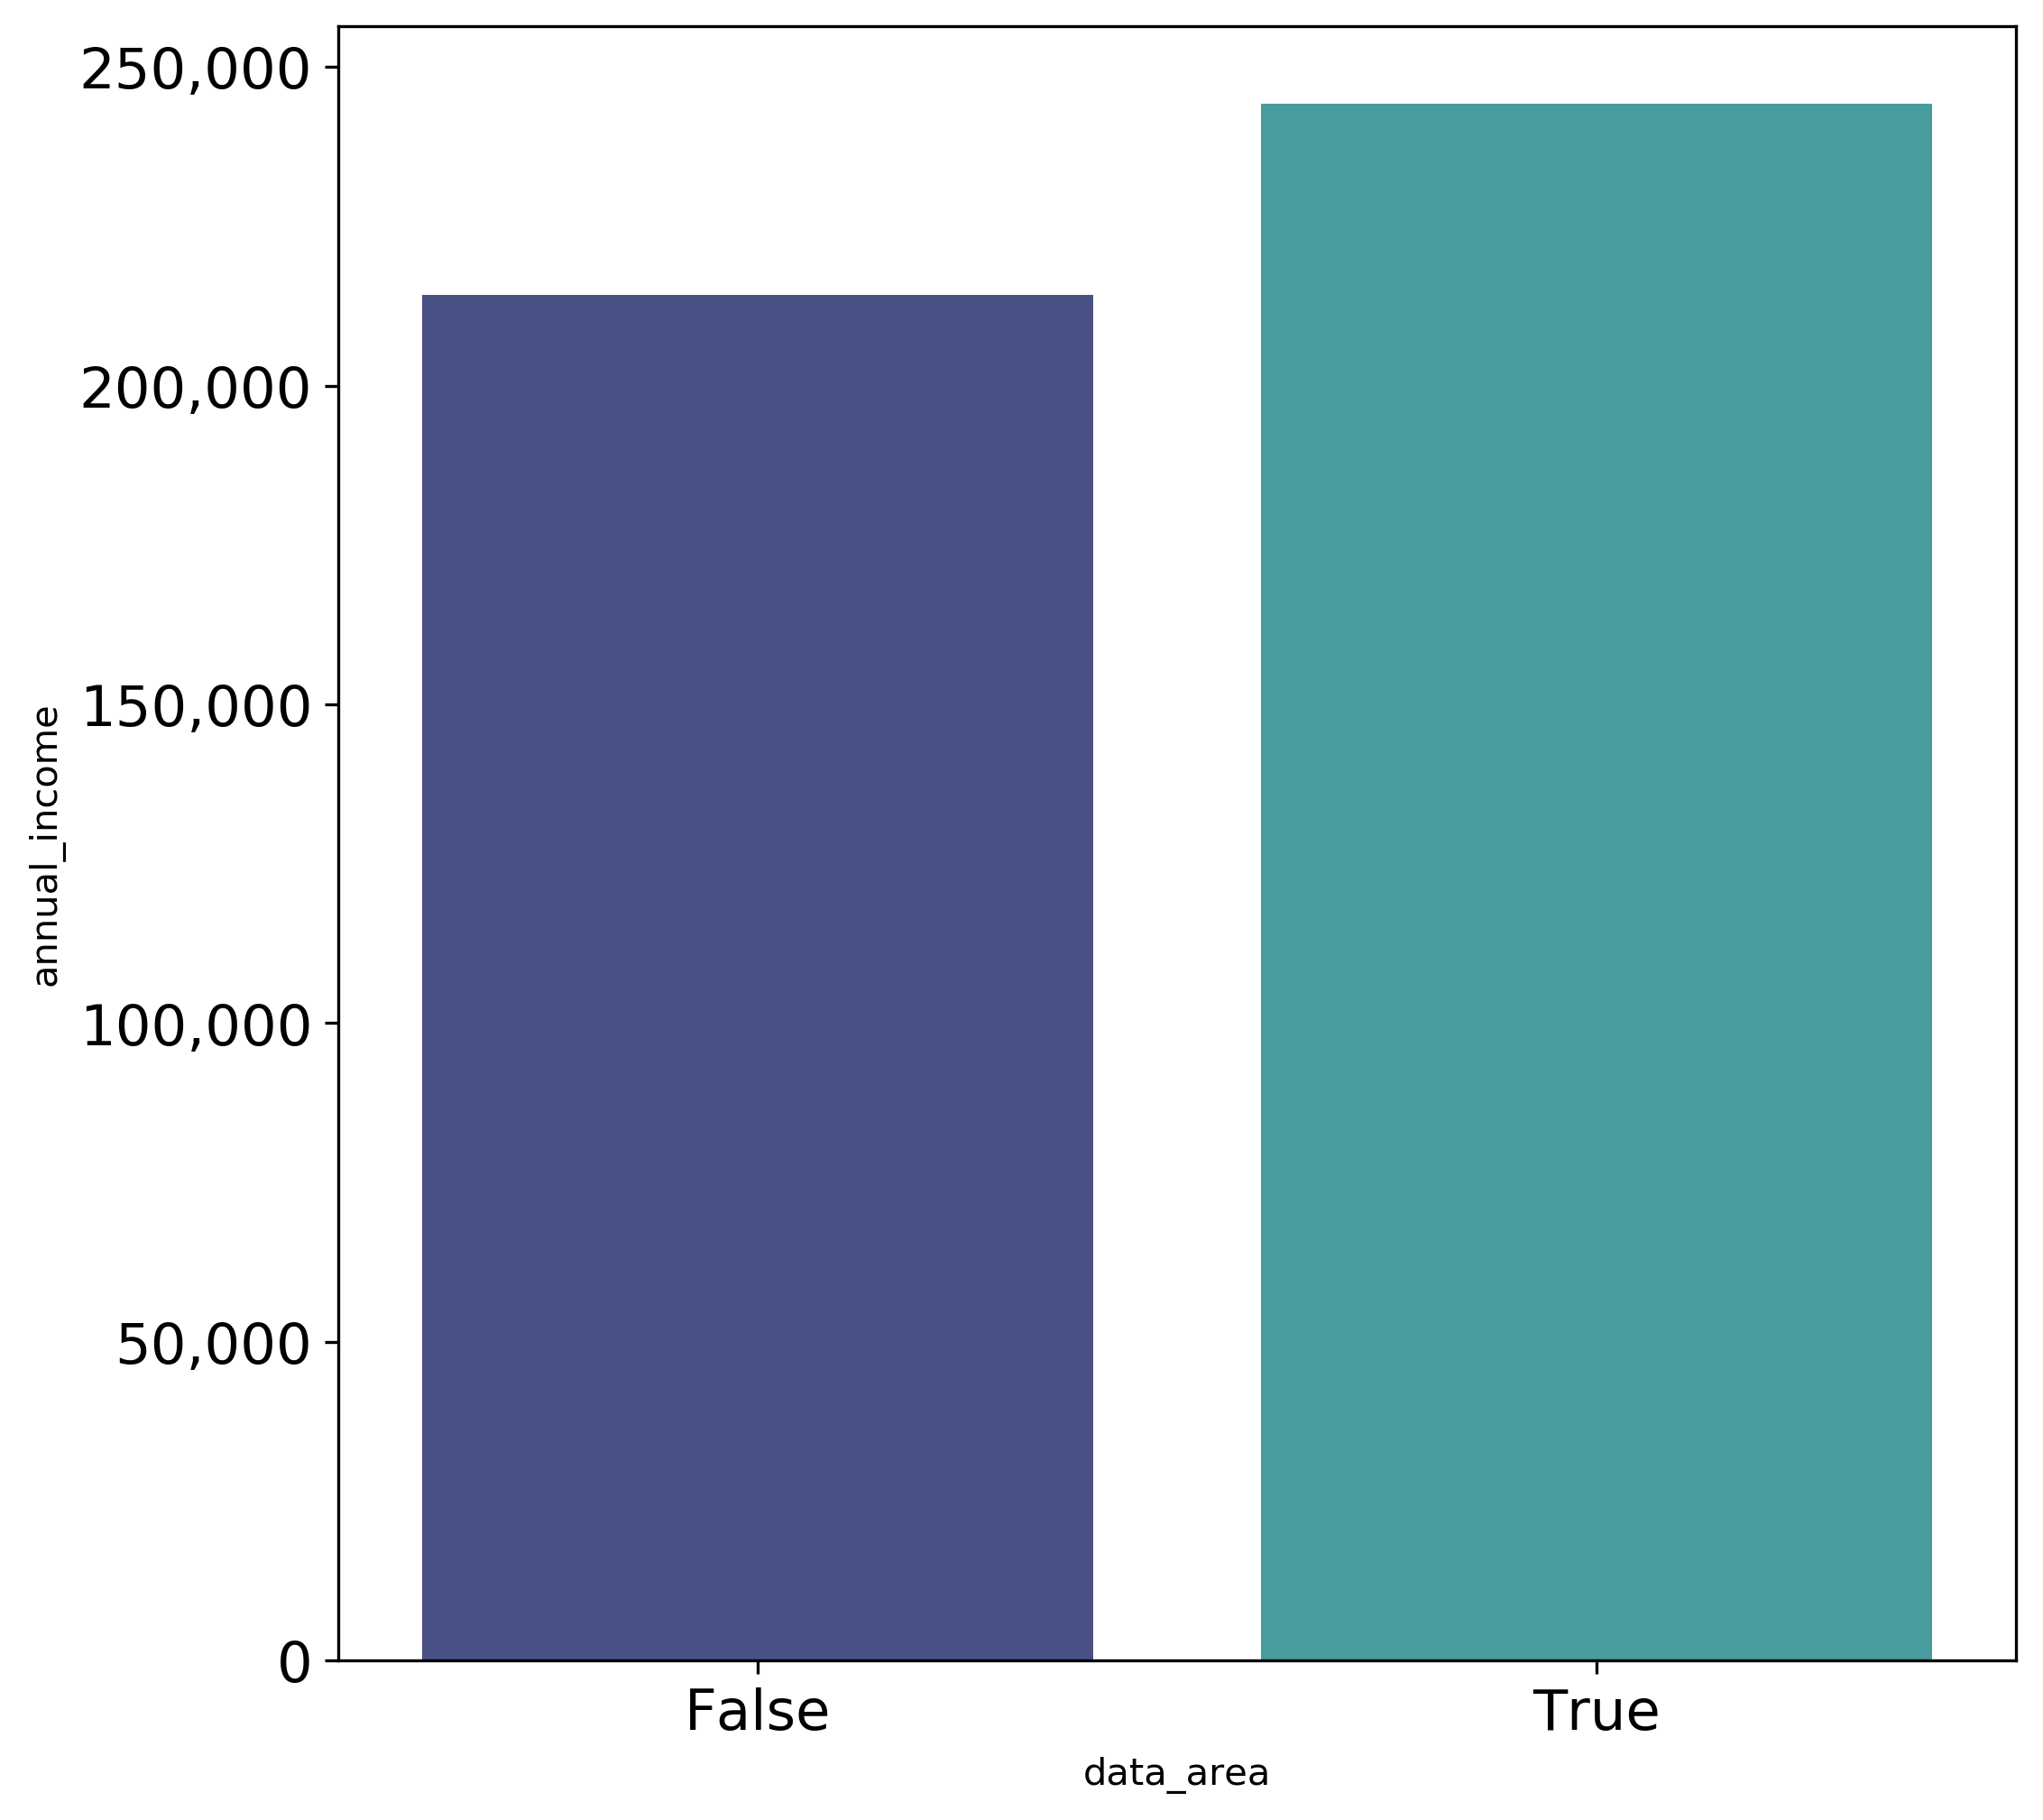

In [122]:
column_avg(df_0_final.copy(), "data_area")
# developer = df_0_final[df_0_final.developer == True]
# temp = developer.groupby("data_area").agg(np.mean)
# temp = temp.reset_index("data_area")
# print(temp.annual_income.values.round(0))
# sns.barplot(data=temp,x="data_area",y=target)

In [123]:
# 데이터 분야 평균 연봉
data_engineer = df_0_final[df_0_final.data_engineer == True][target]
print("data_engineer : ", data_engineer.shape[0], np.round(data_engineer.mean(),0))
data_analytics = df_0_final[df_0_final.data_analytics == True][target]
print("data_analytics : ",data_analytics.shape[0], np.round(data_analytics.mean(),0))
data_scientist = df_0_final[df_0_final.data_scientist == True][target]
print("data_scientist : ", data_scientist.shape[0], np.round(data_scientist.mean(),0))
ai = df_0_final[df_0_final.ai == True][target]
print("ai : ", ai.shape[0], np.round(ai.mean(),0))
machine_learning = df_0_final[df_0_final.machin_learning == True][target]
print("machine_learning", machine_learning.shape[0], np.round(machine_learning.mean(),0))

# np.round(data_engineer,0), np.round(data_analytics,0), np.round(data_scientist,0), np.round(ai,0), np.round(machine_learning,0)

data_engineer :  67 208910.0
data_analytics :  188 197505.0
data_scientist :  122 206311.0
ai :  4266 264628.0
machine_learning 4395 262305.0


In [124]:
len(df_0_final.company.unique())
df_0_final.year.unique()

array([2017, 2018, 2019, 2020, 2021], dtype=int64)

In [125]:
# # 낮은 이상치 : 제1사분위수 - 1.5 * 사분위편차 보다 작은 값
# # 높은 이상치 : 제3사분위수 + 1.5 * 사분위편차 보다 높은 값
# q0 = train[target].quantile(q=0)
# q1 = train[target].quantile(q=0.25)
# q2 = train[target].quantile(q=0.5)
# q3 = train[target].quantile(q=0.75)
# q4 = train[target].quantile(q=1)

# print(q0, q1, q2, q3, q4)
# min = q1 - (1.5 * q1)
# max = q3 + (1.5 * q3)
# print(min, max)


In [126]:


# X = df_0_final.drop(target, axis=1)
# y = df_0_final[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tt, test = train_test_split(df_0_final, test_size=0.2, random_state=42)
train, valid = train_test_split(tt, test_size=0.2, random_state=42)

X_tt, y_tt = tt.drop(target, axis=1), tt[target]
X_train, y_train = train.drop(target, axis=1), train[target]
X_valid, y_valid = valid.drop(target, axis=1), valid[target]
X_test, y_test = test.drop(target, axis=1), test[target]

print(X_tt.shape, X_train.shape, X_valid.shape, X_test.shape)

(49149, 21) (39319, 21) (9830, 21) (12288, 21)


In [127]:
# Scaler set
ct = ColumnTransformer([('somename', StandardScaler(), ['years_of_experience'])], remainder='passthrough')
# scaler = StandardScaler()

# X_train[["years_of_experience"]] = scaler.fit_transform(X_train[["years_of_experience"]])
# X_test[["years_of_experience"]] = scaler.transform(X_test[["years_of_experience"]])

In [128]:
# Linear Regressor

lr_pipe = make_pipeline(
    ct,
    LinearRegression(
        n_jobs=-1,    
    )
)

lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('somename', StandardScaler(),
                                                  ['years_of_experience'])])),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [129]:
baseline = lr_pipe.predict(X_valid)
r2_base = r2_score(y_true=y_valid, y_pred=baseline)
r2_base

0.32932604706100876

In [130]:
# Lasso
alphas = np.arange(1, 10, 1)
alphas = [0.000001, 0.001, 0.01, 1.0, 10]
lasso_pipe = make_pipeline(
    ct,
    LassoCV(
        alphas=alphas,
        cv=5
    ),
)
lasso_pipe.fit(X_train, y_train)
model = lasso_pipe.steps[1][1]
print("alpha: ", model.alpha_)


alpha:  1e-06


In [131]:
pred_lasso = lasso_pipe.predict(X_valid)
r2_lasso = r2_score(y_true=y_valid, y_pred=pred_lasso)
r2_lasso

0.32932604706075663

In [132]:
# Ridge
alphas = [0.000001, 0.001, 0.01, 1.0, 10]
ridge_pipe = make_pipeline(
    ct,
    RidgeCV(
        alphas=alphas,
        cv=5
    ),
)
ridge_pipe.fit(X_train, y_train)
model = ridge_pipe.steps[1][1]
print("alpha: ", model.alpha_)


alpha:  10.0


In [133]:
pred_ridge = ridge_pipe.predict(X_valid)
r2_ridge = r2_score(y_true=y_valid, y_pred=pred_ridge)
r2_ridge

0.32933220188940693

In [134]:
# ElasticNet
# alphas = np.arange(1, 10, 1)
alphas = [0.000001, 0.001, 0.01, 1.0, 10]
en_pipe = make_pipeline(
    ct,
    ElasticNetCV(
        alphas=alphas,
        random_state=42,
        n_jobs=-1,
        cv=5,
    )
)
en_pipe.fit(X_train, y_train)
model = en_pipe.steps[1][1]
print("alpha: ", model.alpha_)

alpha:  0.001


In [135]:
pred_en = en_pipe.predict(X_valid)
r2_en = r2_score(y_true=y_valid, y_pred=pred_en)
r2_en

0.3293329010092607

In [136]:
# RandomForestRegressor
rf_pipe = make_pipeline(
    ct,
    RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    )
)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('somename', StandardScaler(),
                                                  ['years_of_experience'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [137]:
pred_rf = rf_pipe.predict(X_valid)
r2_rf = r2_score(y_true=y_valid,y_pred=pred_rf)
r2_rf

0.6574052303409403

In [138]:
lgb_pipe = make_pipeline(
    ct,
    LGBMRegressor(
        random_state=42,
        n_jobs=-1,
    ),
)

lgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('somename', StandardScaler(),
                                                  ['years_of_experience'])])),
                ('lgbmregressor', LGBMRegressor(random_state=42))])

In [139]:
pred_lgb = lgb_pipe.predict(X_valid)
r2_lgb = r2_score(y_true=y_valid,y_pred=pred_lgb)
r2_lgb

0.6617932709366994

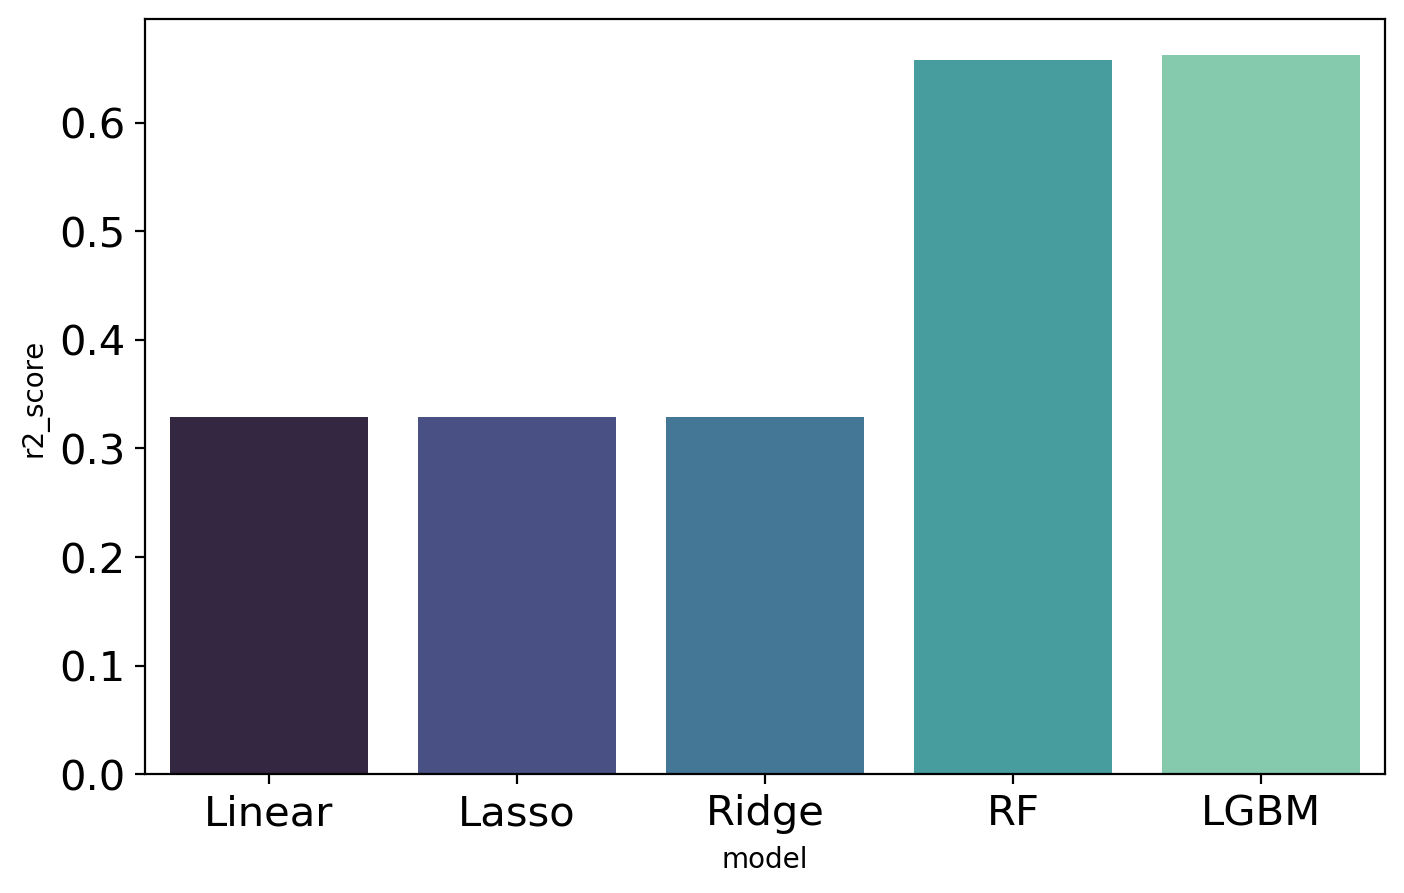

In [140]:
r2_scores = [r2_base,r2_lasso,r2_ridge,r2_rf,r2_lgb]
models = ["Linear","Lasso", "Ridge", "RF", "LGBM"]
df_score = pd.DataFrame({"model" : models,"r2_score" : r2_scores})
df_score
plt.close("all")
plt.figure(figsize=(8,5), dpi=200)
sns.barplot(data=df_score, x="model",y="r2_score", palette="mako")

In [141]:
# light GBM

params = {
    "lgbmregressor__max_depth":        hp.quniform("max_depth", 30, 50, 2),
    "lgbmregressor__num_leaves":       hp.quniform("num_leaves", 40, 80, 5),
    "lgbmregressor__learning_rate":    hp.quniform("learning_rate", 0.1, 0.2, 0.01),
    "lgbmregressor__subsample":        hp.quniform("subsample", 0.5, 1.0, 0.1),
    "lgbmregressor__colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.6),
    "lgbmregressor__n_estimators":     hp.quniform("n_estimators", 1000, 2000, 100),
}


def get_pipe(params):
    params["lgbmregressor__max_depth"] = int(params["lgbmregressor__max_depth"])
    params["lgbmregressor__num_leaves"] = int(params["lgbmregressor__num_leaves"])
    params["lgbmregressor__n_estimators"] = int(params["lgbmregressor__n_estimators"])

    pipe = make_pipeline(
        ct,
        LGBMRegressor(
            # boosting_type='dart',
            random_state=42,
            n_jobs=-1,
            reg_alpha=0.6,
            reg_lambda=0.7,
        ),
    )
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
    avg_cv_score = np.mean(score)
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = Trials()

best_params = fmin(fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=20)

print("Best params : ", trials.best_trial["misc"]["vals"])
print("Best f2 : ", -trials.best_trial["result"]["loss"])


100%|██████████| 20/20 [04:05<00:00, 12.28s/trial, best loss: -0.6690128479727525]
Best params :  {'colsample_bytree': [0.4900156608657521], 'learning_rate': [0.1], 'max_depth': [38.0], 'n_estimators': [2000.0], 'num_leaves': [45.0], 'subsample': [0.8]}
Best f2 :  0.6690128479727525


In [142]:
params_select = {
    "lgbmregressor__max_depth": best_params["max_depth"],
    "lgbmregressor__num_leaves": best_params["num_leaves"],
    "lgbmregressor__learning_rate": best_params["learning_rate"],
    "lgbmregressor__subsample": best_params["subsample"],
    "lgbmregressor__colsample_bytree": best_params["colsample_bytree"],
    "lgbmregressor__n_estimators": best_params["n_estimators"],
    # "lgbmregressor__reg_alpha": best_params["reg_alpha"],
    # "lgbmregressor__reg_lambda": best_params["reg_lambda"],
}
pipe = get_pipe(params_select)
pipe.fit(X_tt, y_tt)
pred_lgbmr = pipe.predict(X_test)
r2_lgbmr = r2_score(y_true=y_test,y_pred=pred_lgbmr)
r2_lgbmr

0.7034700208272655

In [143]:
# # 얼마나 많이 사용되었는가.

# df_importance = pd.DataFrame({"feature" : pipe.feature_names_in_, "importance" : pipe[1].feature_importances_})
# df_importance = df_importance.sort_values(by="importance", ascending=False)
# # importance = pd.DataFrame({"importance" : pipe[1].feature_importances_})
# # df_importance = pd.concat((names, importance), axis=1)
# df_importance

# plt.close("all")
# plt.figure(figsize=(10,10), dpi=300)

# plt.rc('xtick', labelsize=15) 
# plt.rc('ytick', labelsize=15)
# palette = "mako"

# sns.barplot(data=df_importance,x="importance",y="feature", orient="h", palette=palette)

# # put comma
# current_values = plt.gca().get_xticks()
# plt.gca().set_xticklabels([format(int(x),',') for x in current_values])

range(0, 26)


Text(0.5, 0, 'years of experience')

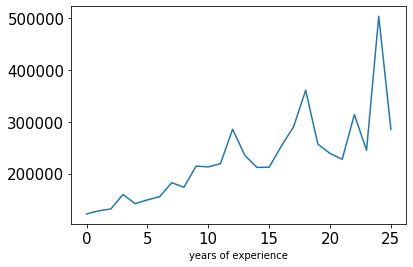

In [144]:
one_datapoint = X_tt.iloc[[7]].copy()
feature_target = "years_of_experience"

feature_range = range(int(X_tt[feature_target].min()),int(X_tt[feature_target].max() + 1))

print(feature_range)
results = []

for year in feature_range:
    one_datapoint[feature_target] = year
    one_dataponit_pred = pipe.predict(one_datapoint)
    results.append(one_dataponit_pred.item())

results = np.array(results)
# results -= results[0]
plt.plot(feature_range, results)
plt.xlabel("years of experience")

In [145]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []
    
    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred = pipe.predict(one_datapoint)
        results.append(one_datapoint_pred.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

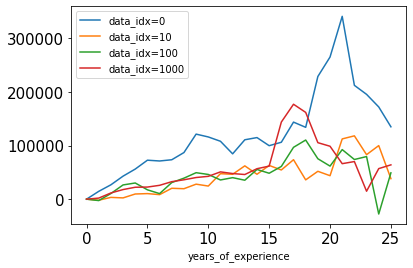

In [146]:
for data_index in [0,10,100,1000]:
    plt.plot(
        *get_ice_plot_data(
            X_test, data_index, feature_target, feature_range
        ),
        label=f"data_idx={data_index}",
    )

plt.xlabel(feature_target)
plt.legend()

In [150]:
# from tqdm import tqdm

# # target_feature = "years_of_experience"
# all_ice_plot_data = []

# for data_index in tqdm(range(len(X_tt))):
#     all_ice_plot_data.append(
#         get_ice_plot_data(
#             X_tt, data_index, feature_target, feature_range
#         )[1]
#     )

  9%|▉         | 4444/49149 [07:47<1:18:26,  9.50it/s]


KeyboardInterrupt: 

In [ ]:
# all_ice_plot_data = np.array(all_ice_plot_data)
# print(all_ice_plot_data.shape)
# pdp_data = all_ice_plot_data.mean()
# print(pdp_data.shape)

# plt.plot(feature_range, pdp_data)
# plt.xlabel(feature_target)
# plt.show()

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2c795d2fef0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2c7998d4208>})

<Figure size 1800x1200 with 0 Axes>

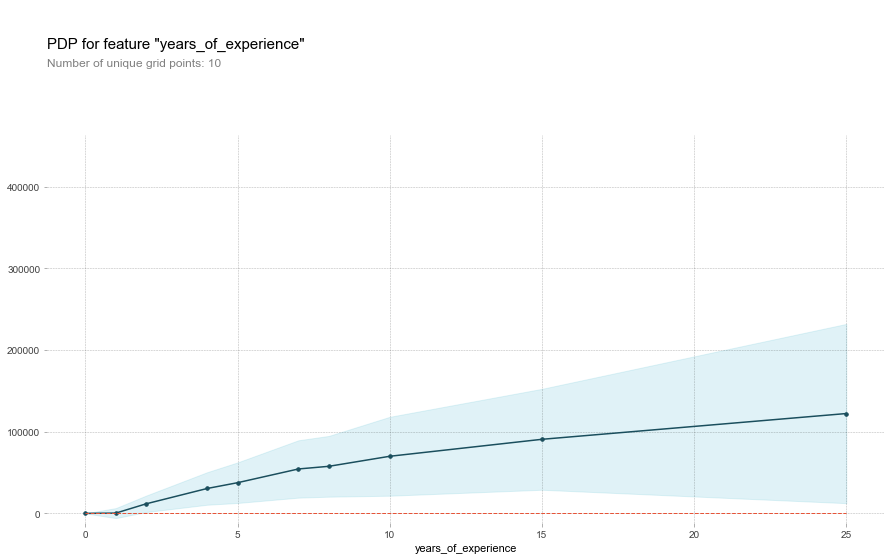

In [151]:
from pdpbox.pdp import pdp_isolate, pdp_plot

plt.figure(dpi=300)

isolated = pdp_isolate(
    model=pipe,
    dataset=X_tt,
    model_features=X_tt.columns,
    feature=feature_target,
    grid_type="percentile",
    num_grid_points=10,
)
pdp_plot(isolated, feature_name=feature_target)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2c7bb209b38>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2c7bb23d828>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2c7bb269c50>}})

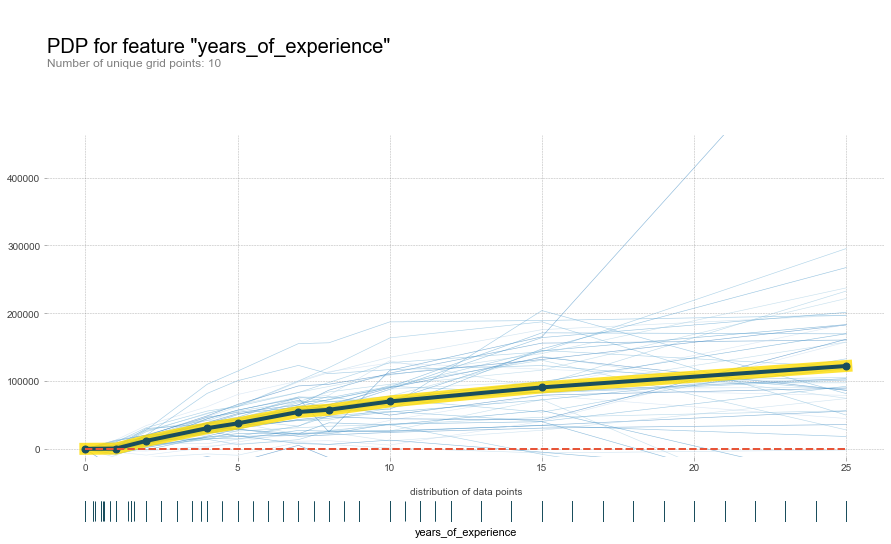

In [180]:
plot_params = {
    # plot title and subtitle
    # 'title': 'PDP for feature "%s"' % feature_name,
    # 'subtitle': "Number of unique grid points: %d" % n_grids,
    'title_fontsize': 20,
    'subtitle_fontsize': 12,
    'font_family': 'Arial',
    # 'font_size': 40,
    # matplotlib color map for ICE lines
    'line_cmap': 'Blues',
    'xticks_rotation': 0,
    'xticks_fontsize': 20,
    # pdp line color, highlight color and line width
    'pdp_color': '#1A4E5D',
    'pdp_hl_color': '#FEDC00',
    'pdp_linewidth': 4,
    # horizon zero line color and with
    'zero_color': '#E75438',
    'zero_linewidth': 2,
    # pdp std fill color and alpha
    'fill_color': '#66C2D7',
    'fill_alpha': 1,
    # marker size for pdp line
    'markersize': 7,
}

pdp_plot(
    isolated,
    feature_name=feature_target,
    plot_lines=True,
    frac_to_plot=50,
    plot_pts_dist=True,
    plot_params=plot_params,
)

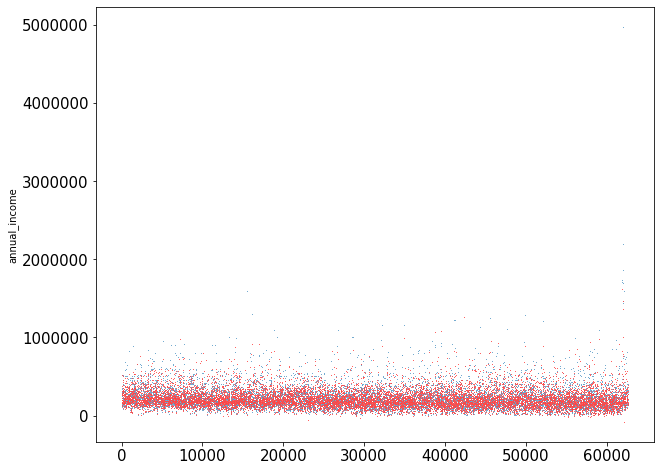

In [148]:
plt.close("all")
plt.figure(figsize=(10,8))
sns.scatterplot(data=X_test,x=X_test.index,y=y_test,s=1)
# sns.scatterplot(data=X_test,x=X_test.index,y=baseline,s=1,color="red")
# sns.scatterplot(data=X_test,x=X_test.index,y=pred_rf,s=1,color="green")
sns.scatterplot(data=X_test,x=X_test.index,y=pred_lgbmr,s=1,color="red")
# plt.scatter(x=X_test.index,y=y_test)

In [149]:
# df = pd.read_csv("data_1_india_data_field.csv")
# print(df.shape)
# df.head(5).T